In [49]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

In [50]:
url = "https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/creditcard.csv"

creditcard = pd.read_csv(url)

creditcard.columns = [x.lower() for x in creditcard.columns]
creditcard.rename(columns = {'class': 'fraud'}, inplace = True)

print(creditcard.columns)
print(creditcard.fraud.value_counts(dropna = False))

X = creditcard.drop("fraud", axis = 1)
y = creditcard["fraud"]


X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'fraud'],
      dtype='object')
0    56772
1      102
Name: fraud, dtype: int64


In [51]:
xg_cl= xgb.XGBClassifier(objective='binary:logistic',n_estimators=10,seed=123)

xg_cl.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
       subsample=1, verbosity=1)

Predicted fraud count  28


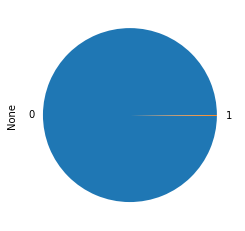

In [52]:
y_pred=xg_cl.predict(X_test)

print("Predicted fraud count ",len(y_pred[y_pred==1]))
buffer=pd.Series(y_pred)
buffer.value_counts().plot(kind='pie')
plt.show()



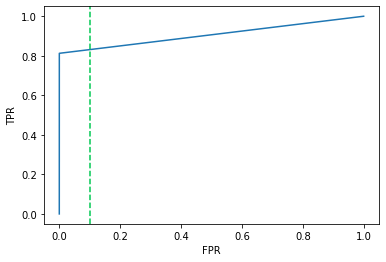

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)   # precision_recall_curve
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

_ = plt.figure()
plt.plot(roc.FPR, roc.TPR)
plt.axvline(0.1, color = '#00C851', linestyle = '--')
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.show()

In [54]:
accuracy = float(np.sum(y_pred==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.999531


In [55]:
#cross validation

dmatrix=xgb.DMatrix(data=creditcard.iloc[:,:-1],
    label=creditcard.fraud)
params={"objective":"binary:logistic","max_depth":4}

cv_results=xgb.cv(dtrain=dmatrix, params=params, nfold=4,
    num_boost_round=10, metrics='error', as_pandas=True)

print("Accuracy: %f" %((1-cv_results["test-error-mean"]).iloc[-1]))

Accuracy: 0.999420


In [56]:
# cross validation area under curve
cv_results = xgb.cv(dtrain=dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.941189       0.004627       0.909967      0.034740
1        0.943558       0.006600       0.915366      0.036943
2        0.945969       0.003573       0.915361      0.036955
3        0.945969       0.003578       0.915358      0.036955
4        0.948365       0.002271       0.945640      0.007842
0.9456403333333333


In [57]:
from sklearn.metrics import roc_auc_score

auc= roc_auc_score(y_test, y_pred)

print(auc)

0.9061912835417768
